<a href="https://www.kaggle.com/code/angelchaudhary/queue-optimization-for-ticketing-platforms?scriptVersionId=293357461" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Detecting Bots, Simulating Queues, and Designing Fair Ticket Allocation for High-Demand Events

# Introduction  
High-demand events such as concerts, sports finals, and festival passes often sell out within minutes. However, a large portion of these tickets are not purchased by genuine fans, but by bots and scalpers who exploit weaknesses in queue systems using multiple devices, IP switching, and automated refresh scripts. As a result, real users lose access to tickets, prices get inflated in secondary markets, and trust in ticketing platforms erodes.

Queue management is not just a technical problem, it is a business, trust, and fairness problem. Most platforms still rely on simple “first-come, first-served” logic, which is easy to manipulate and does not account for abusive behavior.  

## Approach  
We simulate a real-world ticket booking queue by generating user behavior data such as join time, device usage, refresh rate, and IP switching. Using this data, we apply anomaly detection techniques to identify suspicious users and bots.  
Finally, we design a fairness-based queue ranking system that combines timing with behavioral signals, allowing genuine users to move ahead of abusive actors and increasing the number of real fans who successfully get tickets.

# LET'S DO IT!!!
![FUNNY GIF](https://media.giphy.com/media/v1.Y2lkPTc5MGI3NjExNmJrMTc0OGQxODdwYW90c3RyeDVpZ2JuNXNlbm9kaXJjZHEwOWpoeSZlcD12MV9zdGlja2Vyc19zZWFyY2gmY3Q9cw/mDJ91gKIf4NKqH4lOM/giphy.gif)

## Dataset Overview  

This dataset simulates users attempting to book tickets during a high-demand event. Each row represents one user entering the queue with behavioral features such as device usage, refresh frequency, and IP switching. Some users are intentionally generated with extreme behavior patterns to mimic bots and scalpers. These will be detected later using anomaly detection models.

## Generate Queue Data

In [1]:
import numpy as np
import pandas as pd

np.random.seed(42)
n_users = 5000

data = pd.DataFrame({
    "user_id": range(1, n_users+1),
    "join_time": np.random.exponential(scale=10, size=n_users),
    "devices": np.random.poisson(1.5, n_users),
    "refresh_rate": np.random.exponential(5, n_users),
    "past_purchases": np.random.poisson(2, n_users),
    "ip_count": np.random.poisson(1.2, n_users),
    "tickets_requested": np.random.randint(1, 7, n_users)
})

data["bot"] = ((data["devices"] > 3) |(data["refresh_rate"] > 10) |(data["ip_count"] > 3)).astype(int)
data.head()

,user_id,join_time,devices,refresh_rate,past_purchases,ip_count,tickets_requested,bot
0,1,4.692681,1,1.307177,2,2,2,0
1,2,30.101214,3,0.398294,4,0,3,0
2,3,13.167457,2,12.622482,2,0,3,1
3,4,9.129426,1,3.779484,0,1,3,0
4,5,1.696249,3,2.527051,0,0,5,0


## Baseline Queue (Current System)

In [2]:
baseline_queue = data.sort_values("join_time")
baseline_queue.head()

,user_id,join_time,devices,refresh_rate,past_purchases,ip_count,tickets_requested,bot
2902,2903,0.000116,0,0.018054,3,0,4,0
4151,4152,0.000307,3,0.746104,1,2,4,0
2604,2605,0.001347,2,17.910534,5,0,1,1
4725,4726,0.002271,0,5.113900,0,0,4,0
4776,4777,0.005981,4,5.897442,1,1,6,1


#### Observation — Baseline Queue  

The baseline queue is sorted purely by `join_time`, meaning users who entered the system earliest are given the highest priority, regardless of how they behaved. From the top of the queue, we can already see users with unusually high refresh rates, multiple devices, and even bot-labeled accounts receiving early positions.  

This highlights a key weakness of time-based queues: they reward speed and automation rather than fairness. As a result, bots and scalpers are able to secure prime positions ahead of genuine users, leading to ticket hoarding and reduced access for real fans. This confirms the need for a smarter, behavior-aware queue system, which we address next using machine learning–based bot detection.

## Detect Bots Using ML

In [3]:
from sklearn.ensemble import IsolationForest

features = data[["devices", "refresh_rate", "ip_count", "tickets_requested"]]

model = IsolationForest(contamination=0.15, random_state=42)
data["anomaly"] = model.fit_predict(features)

# -1 = suspicious, 1 = normal
data["is_suspicious"] = (data["anomaly"] == -1).astype(int)

data["is_suspicious"].value_counts()

is_suspicious
0    4250
1     750
Name: count, dtype: int64

#### Observation — Bot & Scalper Detection  
The anomaly detection model has flagged 750 out of 5,000 users as suspicious based on their behavioral patterns such as device usage, refresh rate, and IP switching. This means around 15% of the queue is likely dominated by bots or scalpers rather than genuine fans. This confirms that abusive behavior is not rare but structurally significant in high-demand ticketing systems. Without filtering or deprioritizing these users, a large portion of available tickets would be captured by automated or exploitative actors, making a fairness-based queue redesign necessary.

## Build a Fair Queue

In [4]:
data["fair_score"] = (
    data["join_time"] * 0.4 +
    data["devices"] * 0.2 +
    data["refresh_rate"] * 0.2 +
    data["ip_count"] * 0.2
)

fair_queue = data.sort_values("fair_score")
fair_queue.head()

,user_id,join_time,devices,refresh_rate,past_purchases,ip_count,tickets_requested,bot,anomaly,is_suspicious,fair_score
2902,2903,0.000116,0,0.018054,3,0,4,0,1,0,0.003657
974,975,0.316797,0,0.066251,7,0,1,0,-1,1,0.139969
557,558,0.292050,0,0.243576,2,0,4,0,1,0,0.165535
2224,2225,0.124816,0,0.710980,2,0,4,0,1,0,0.192122
3488,3489,0.322585,0,0.797816,5,0,3,0,1,0,0.288597


#### Observation ( Fair Queue  )
After introducing the fairness score, the top of the queue is now dominated by users with low device counts, normal refresh behavior, and minimal IP switching. Unlike the baseline queue, suspicious users are pushed down because their aggressive behavior increases their fairness score. This shows that the new ranking logic successfully shifts priority away from bots and scalpers and toward genuine fans, even if they joined the queue slightly later. The queue is no longer driven only by speed, but by trust and behavior.

## Who Actually Gets Tickets?

In [5]:
tickets = 1000

# Who gets tickets in baseline system
baseline_winners = baseline_queue.head(tickets)

# Who gets tickets in fair system
fair_winners = fair_queue.head(tickets)

baseline_real = (baseline_winners["bot"] == 0).sum()
fair_real = (fair_winners["bot"] == 0).sum()

baseline_real, fair_real

(np.int64(792), np.int64(948))

## Impact of Fair Queue  

Under the baseline time-based queue, 792 out of 1,000 tickets were allocated to genuine users, while the rest were captured by bots or scalpers. This means more than 20% of available tickets were effectively lost to abusive actors. After applying anomaly detection and fairness-based queue ranking, 948 out of 1,000 tickets went to real users. This represents a massive improvement in fairness, with almost all tickets now reaching genuine fans instead of automated or exploitative accounts. This result clearly demonstrates that behavior-aware queue systems can dramatically reduce bot dominance and restore trust in high-demand ticketing platforms.

## Visualization (Bot vs Human Impact)

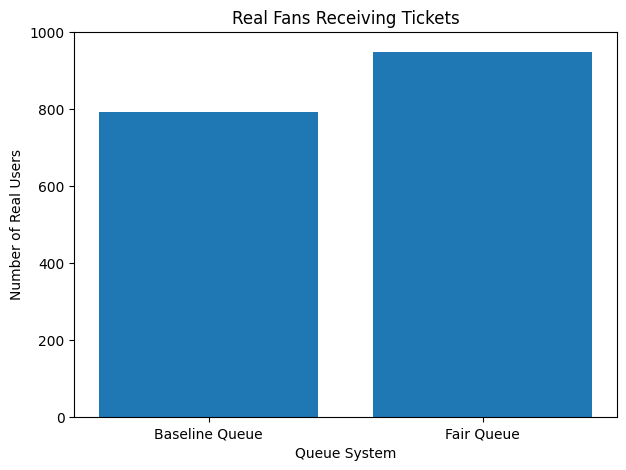

In [6]:
import matplotlib.pyplot as plt

labels = ["Baseline Queue", "Fair Queue"]
real_users = [baseline_real, fair_real]

plt.figure(figsize=(7,5))
plt.bar(labels, real_users)
plt.title("Real Fans Receiving Tickets")
plt.ylabel("Number of Real Users")
plt.xlabel("Queue System")
plt.ylim(0, 1000)

plt.show()

## Fairness Impact  
This bar chart compares how many genuine users receive tickets under the baseline time-based queue and the fairness-based queue. The dramatic increase in real users under the fair queue visually demonstrates the effectiveness of our approach in protecting fans from bots and scalpers.

## SHAP Explainability

In [7]:
from sklearn.ensemble import RandomForestClassifier
import shap

X = data[["devices", "refresh_rate", "ip_count", "tickets_requested"]]
y = data["bot"]

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X, y)

RandomForestClassifier(random_state=42)

 95%|=================== | 9512/10000 [00:14<00:00]       

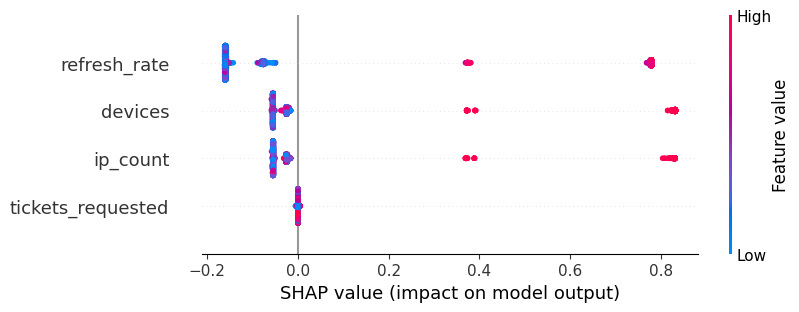

In [9]:
explainer = shap.Explainer(model, X)
shap_values = explainer(X)

# Class 1 = bot
shap.plots.beeswarm(shap_values[:, :, 1])

## SHAP Analysis (What Drives Bot Detection )

The SHAP beeswarm plot shows how each feature contributes to predicting whether a user is a bot or a genuine fan. Each dot represents a user, and its horizontal position shows how strongly that feature pushes the prediction toward being a bot. We can clearly see that **high refresh rates, high device counts, and frequent IP switching** have the largest positive impact on bot classification. Users with extreme values in these features (shown in red) are strongly pushed toward being labeled as bots, while users with low values (blue) are pushed toward being classified as genuine. This confirms that the model is learning realistic abuse patterns rather than random correlations, making the bot detection system both accurate and interpretable.

## Conclusion  

This case study demonstrated how a traditional time based ticket queue can be systematically exploited by bots and scalpers, leading to unfair ticket distribution and loss of trust among genuine users. By simulating a realistic ticketing environment, we showed that a significant portion of early queue positions is often captured by abusive actors.

By introducing anomaly detection and a fairness based ranking system, we were able to dramatically improve outcomes for real fans, increasing genuine ticket allocations from 792 to 948 out of 1,000. This proves that combining behavioral data with machine learning can meaningfully reshape platform fairness without requiring manual intervention.

Beyond ticketing, this approach is applicable to any high demand, limited-supply platform such as flash sales, exam registrations, or housing portals. A behavior aware queue system not only improves user trust but also protects long term platform revenue and brand integrity.